In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# sampleData
file_path = '/content/drive/addhereyourdataset.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None) # to see all the columns in pandas dataframe
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # the size of the figure

# converting date object to datetime, This is more efficient than converting it after reading using pd.to_datetime().
df = pd.read_csv(file_path, parse_dates=['Date'])
# df.set_index('Date', inplace=True)
df.set_index(pd.to_datetime(df.Date),inplace=True) # we want to keep the date column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.head()

,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0
2018-06-25,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0
2018-06-26,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0
2018-06-27,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0
2018-06-28,2018-06-28,4,True,False,1701,1682,559,0.36,18.29,57.0,6,1025,8,0,0,25,-1,0.0,0.00000,0.0,0.00000,0.0,0.0,403.96356,329.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(116, 42)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 2018-06-24 to 2018-10-17
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    116 non-null    datetime64[ns]
 1   Day of Week             116 non-null    int64         
 2   Is Weekday              116 non-null    bool          
 3   Is Weekend              116 non-null    bool          
 4   Calories Burned         116 non-null    int64         
 5   Calories BMR            116 non-null    int64         
 6   Steps                   116 non-null    int64         
 7   Distance (Km)           116 non-null    float64       
 8   Elevation (Ft)          116 non-null    float64       
 9   Resting Heart Rate      101 non-null    float64       
 10  Floors                  116 non-null    int64         
 11  Minutes Sedentary       116 non-null    int64         
 12  Minutes Lightly Active  116 non

**Building new columns and sanitising the data**

Firstly will be removing the activity where there were no steps recorded. For sleep data, we will clear out rows where there was no "Deep Sleep" entries

In [ ]:
# map the numbers to day names

day_names = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
min_names = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = { 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
#

def is_nan(x):
  return pd.isna(x)        #(x is np.nan or x!=x)

def define_sleep_bucket(row):
  sleep_entry = row['Sleep Start time']
  if not is_nan(sleep_entry):
        # Convert string to time object
        sleepTimeO = datetime.datetime.strptime(sleep_entry, '%Y-%m-%dT%H:%M:%S.000').time()

        # Bucket logic
        if sleepTimeO.minute == 0:
            return sleepTimeO.hour
        elif sleepTimeO.minute <= 30:
            return sleepTimeO.hour + 0.5
        elif sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)

  else:
      return np.nan

def define_awake_bucket(row):
    awake_Entry = row['Sleep End time']
    if not is_nan(awake_Entry):
        # Convert string to time object
        awakeEntryO = datetime.datetime.strptime(awake_Entry, '%Y-%m-%dT%H:%M:%S.000').time()

        # Bucket logic
        if awakeEntryO.minute == 0:
            return awakeEntryO.hour
        elif awakeEntryO.minute <= 30:
            return (awakeEntryO.hour + 0.5)
        elif awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)

    else:
        return np.nan


#remove all entries where there was no steps recorded. i.e no activity
df = df[df['Steps'].notnull()]

df['Day Label'] = df['Day of Week'].apply(lambda x: days[x])
df['Active exercise'] = df['Minutes Very Active'] > 40

#Build additional Sleep columns
df['Sleep Bucket'] = df.apply(define_sleep_bucket, axis=1)
df['Awake Bucket'] = df.apply(define_awake_bucket, axis=1)

df['% Awake'] = 100 - (df['% Deep sleep'] + df['% REM sleep'] + df['% Light sleep'])
df['% Restorative sleep'] = df['% Deep sleep'] + df['% REM sleep']
df['Restorative sleep mins'] = df['Minutes Deep sleep'] + df['Minutes REM sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = df[df['% Deep sleep'].notnull()]


In [ ]:
df.describe()

,Date,Day of Week,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep
count,116,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,101.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,80.000000,76.000000,80.0,80.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,2018-08-20 12:00:00,3.974138,2724.560345,1626.422414,8316.163793,5.474741,26.065776,61.267327,8.551724,832.810345,187.767241,24.681034,37.258621,1240.034483,-1.0,7.883495,76.047703,143.631068,752.596613,0.601942,7.668976,1748.720968,1072.893204,95.712500,375.776316,0.0,420.325000,73.526316,3.750000,221.815789,29.723684,80.434211,7.736842,52.842105,30.355263,17.697368,52.250000,19.171053
min,2018-06-24 00:00:00,1.000000,522.000000,469.000000,0.000000,0.000000,0.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.773540,171.000000,89.000000,195.000000,0.0,113.000000,37.000000,1.000000,109.000000,18.000000,21.000000,2.000000,24.000000,16.000000,9.000000,41.000000,10.000000
25%,2018-07-22 18:00:00,2.000000,2521.750000,1680.000000,6295.750000,4.045000,9.140000,59.000000,3.000000,682.750000,163.750000,4.750000,2.000000,913.500000,-1.0,0.000000,0.000000,74.000000,433.359345,0.000000,0.000000,1630.309950,1039.500000,95.000000,364.250000,0.0,406.750000,60.750000,3.000000,201.750000,27.000000,66.750000,6.000000,44.750000,28.000000,15.000000,48.000000,16.000000
50%,2018-08-20 12:00:00,4.000000,2877.500000,1680.000000,8630.000000,5.565000,21.340000,62.000000,7.000000,745.500000,198.500000,23.000000,30.500000,1380.000000,-1.0,4.000000,30.583260,144.000000,796.114620,0.000000,0.000000,1902.973380,1185.000000,96.000000,379.500000,0.0,431.000000,73.500000,4.000000,223.000000,30.000000,77.500000,7.000000,51.500000,31.000000,18.000000,53.000000,19.000000
75%,2018-09-18 06:00:00,6.000000,3116.750000,1680.000000,11275.000000,7.377500,33.530000,63.000000,11.000000,1049.250000,243.250000,38.250000,64.000000,1647.500000,-1.0,13.000000,128.731190,200.500000,1047.770865,0.000000,0.000000,2070.260335,1253.500000,97.000000,394.000000,0.0,444.000000,83.000000,5.000000,244.750000,33.000000,94.250000,9.000000,58.250000,33.250000,20.000000,57.000000,23.000000
max,2018-10-17 00:00:00,7.000000,4085.000000,1690.000000,25570.000000,16.620000,320.040000,68.000000,105.000000,1440.000000,581.000000,78.000000,135.000000,3089.000000,-1.0,49.000000,548.374750,517.000000,1736.347200,10.000000,123.341330,2452.870800,1403.000000,99.000000,489.000000,0.0,574.000000,113.000000,6.000000,316.000000,44.000000,145.000000,17.000000,92.000000,41.000000,26.000000,63.000000,30.000000
std,NaN,2.023605,653.985218,233.791031,4398.676997,2.959660,36.176807,3.036087,11.869101,309.649982,100.007944,20.114714,35.085268,648.341214,0.0,10.061868,99.803739,91.585917,417.497794,1.762016,22.699727,507.443689,301.403772,2.371742,42.607855,0.0,67.847889,17.412236,1.121011,34.639750,5.069119,21.642757,2.792220,13.285634,5.280666,3.662494,5.713434,4.558913


In [ ]:
# quick glance how does does the numbers behave on weekdays vs weekends

weekday_data = df.groupby('Is Weekday').mean(numeric_only=True)
weekday_data

,Day of Week,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep
Is Weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,6.515152,1.0,2679.545455,1667.606061,8789.909091,5.716061,33.527879,61.666667,11.000000,943.090909,215.515152,20.181818,26.272727,1222.242424,-1.0,7.037037,54.388412,136.666667,659.956047,0.074074,0.950886,1774.602004,1025.777778,95.380952,376.450000,0.0,414.428571,73.150000,3.400,219.250000,28.900000,84.050000,7.650000,51.900000,28.850000,17.750000,51.750000,19.750000
True,2.963855,0.0,2742.457831,1610.048193,8127.807229,5.378795,23.098916,61.121622,7.578313,788.963855,176.734940,26.469880,41.626506,1247.108434,-1.0,8.184211,83.742450,146.105263,785.508394,0.789474,10.055665,1739.526390,1089.631579,95.830508,375.535714,0.0,422.423729,73.660714,3.875,222.732143,30.017857,79.142857,7.767857,53.178571,30.892857,17.678571,52.428571,18.964286


In [ ]:
week_data = df.groupby(['Day of Week']).mean(numeric_only=True)
week_data

,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,2766.764706,1679.764706,7474.117647,4.756471,35.142353,61.200000,11.529412,892.235294,197.647059,27.470588,24.470588,1188.058824,-1.0,3.933333,39.324835,147.266667,723.268431,0.000000,0.000000,1884.135575,1165.733333,95.875000,374.200000,0.0,425.812500,68.533333,3.533333,226.200000,29.600000,79.466667,8.133333,52.866667,30.866667,16.466667,53.400000,19.066667
2,1.0,0.0,2932.000000,1613.529412,9709.941176,6.495294,19.542941,60.625000,6.411765,695.588235,192.470588,31.411765,62.705882,1517.058824,-1.0,9.823529,102.797649,160.176471,917.109046,1.058824,13.772624,1782.886879,1125.058824,94.846154,377.416667,0.0,427.538462,72.666667,3.833333,225.333333,29.750000,79.416667,8.000000,52.833333,31.166667,17.583333,52.750000,19.000000
3,1.0,0.0,2848.588235,1611.411765,8856.588235,5.938235,22.770000,60.823529,7.470588,749.647059,179.705882,31.176471,51.411765,1370.058824,-1.0,9.117647,90.933628,153.647059,835.312679,0.823529,10.401669,1620.286221,1010.647059,96.769231,371.230769,0.0,419.615385,75.307692,4.153846,217.384615,30.384615,78.538462,6.923077,48.384615,30.769231,18.384615,52.230769,19.153846
4,1.0,0.0,2695.375000,1604.187500,7546.250000,5.081250,20.955000,61.500000,6.875000,806.750000,166.437500,26.625000,38.187500,1184.937500,-1.0,10.142857,101.458271,150.642857,810.832673,0.571429,6.402520,1711.505051,1085.357143,96.000000,386.363636,0.0,443.636364,83.000000,4.272727,224.454545,31.000000,78.909091,8.181818,57.272727,31.545455,19.181818,51.272727,18.181818
5,1.0,0.0,2449.562500,1536.687500,6948.562500,4.556875,16.574375,61.666667,5.437500,802.437500,144.937500,15.000000,30.500000,954.562500,-1.0,7.615385,81.592786,111.615385,592.829592,1.538462,20.279408,1702.073737,1063.384615,95.500000,362.400000,0.0,369.500000,66.600000,3.400000,216.200000,28.800000,79.600000,7.400000,58.400000,29.200000,16.400000,51.800000,19.800000
6,0.0,1.0,2884.000000,1679.500000,10655.500000,6.877500,43.625000,62.076923,14.312500,955.437500,228.187500,26.875000,36.687500,1424.812500,-1.0,6.538462,55.732043,173.769231,903.743161,0.076923,0.951635,1759.771382,994.000000,95.500000,361.100000,0.0,412.500000,66.600000,3.300000,207.700000,28.400000,86.800000,8.000000,51.400000,27.600000,17.100000,51.200000,20.900000
7,0.0,1.0,2487.117647,1656.411765,7034.058824,4.622941,24.024706,61.285714,7.882353,931.470588,203.588235,13.882353,16.470588,1031.588235,-1.0,7.500000,53.140755,102.214286,433.582299,0.071429,0.950190,1788.373296,1055.285714,95.272727,391.800000,0.0,416.181818,79.700000,3.500000,230.800000,29.400000,81.300000,7.300000,52.400000,30.100000,18.400000,52.300000,18.600000


In [ ]:
def getDayLabel(dayNum):
    return day_names[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

In [ ]:
# activity analysis

df[['Calories Burned', 'Steps', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes', 'Active exercise', 'Resting Heart Rate']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories Burned,116.0,2724.560345,653.985218,522.0,2521.75,2877.5,3116.75,4085.0
Steps,116.0,8316.163793,4398.676997,0.0,6295.75,8630.0,11275.00,25570.0
Minutes Sedentary,116.0,832.810345,309.649982,0.0,682.75,745.5,1049.25,1440.0
Minutes Fairly Active,116.0,24.681034,20.114714,0.0,4.75,23.0,38.25,78.0
Minutes Very Active,116.0,37.258621,35.085268,0.0,2.00,30.5,64.00,135.0
Cardio minutes,103.0,7.883495,10.061868,0.0,0.00,4.0,13.00,49.0
Fat Burn minutes,103.0,143.631068,91.585917,0.0,74.00,144.0,200.50,517.0
Resting Heart Rate,101.0,61.267327,3.036087,55.0,59.00,62.0,63.00,68.0


Text(0, 0.5, 'Minutes Very Active')

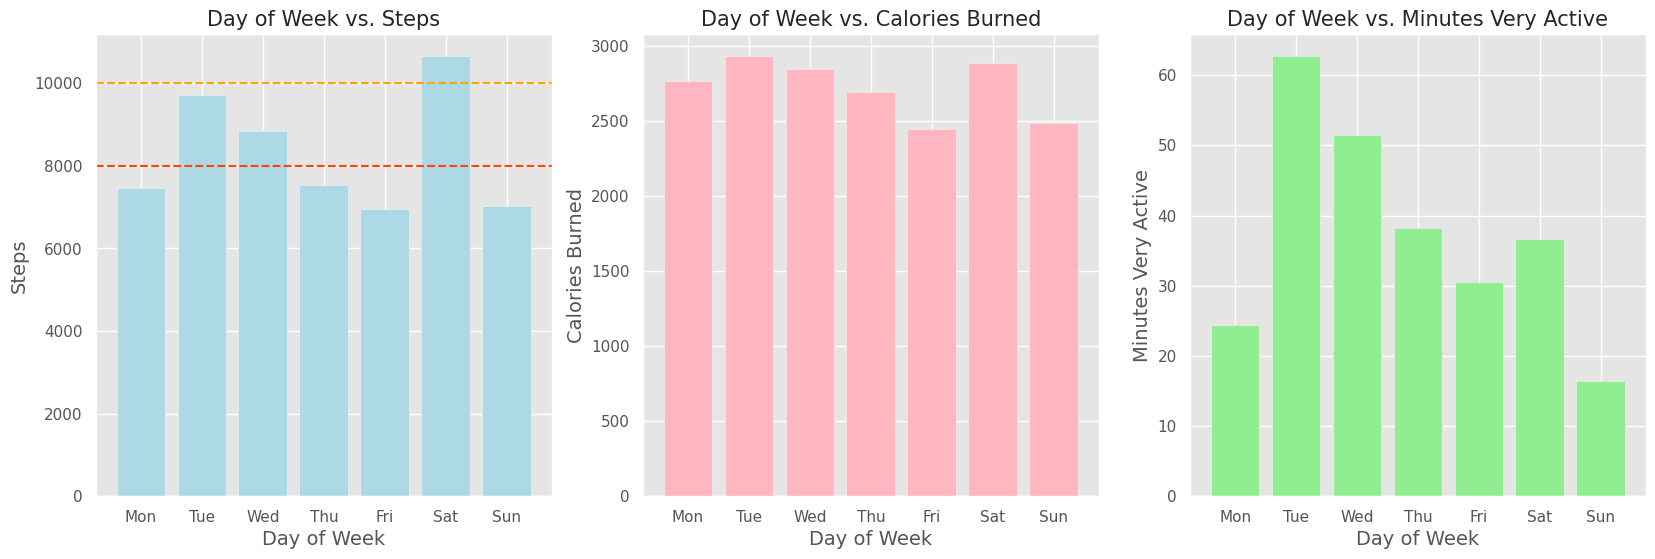

In [ ]:
fig = plt.figure(figsize = (20,6))

# daily steps
ax = plt.subplot(131)
plt.bar(week_data.index, week_data['Steps'], color='lightblue')
plt.title('Day of Week vs. Steps', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Steps', fontsize=14)
ax.axhline(8000, color="orangered", linestyle='--')
ax.axhline(10000, color="orange", linestyle='--')
ax.set_xticklabels(min_names)

# ------------------ #

# daily calorie burn
ax2 = fig.add_subplot(132)
plt.bar(week_data.index, week_data['Calories Burned'], color='lightpink')
plt.title('Day of Week vs. Calories Burned', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Calories Burned', fontsize=14)
ax2.set_xticklabels(min_names)

# ------------------ #

# daily activity time

ax3 = fig.add_subplot(133)
ax3.set_xticklabels(min_names)
plt.bar(week_data.index, week_data['Minutes Very Active'], color='lightgreen')
plt.title('Day of Week vs. Minutes Very Active', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes Very Active', fontsize=14)


Text(0, 0.5, 'Minutes Sedentary')

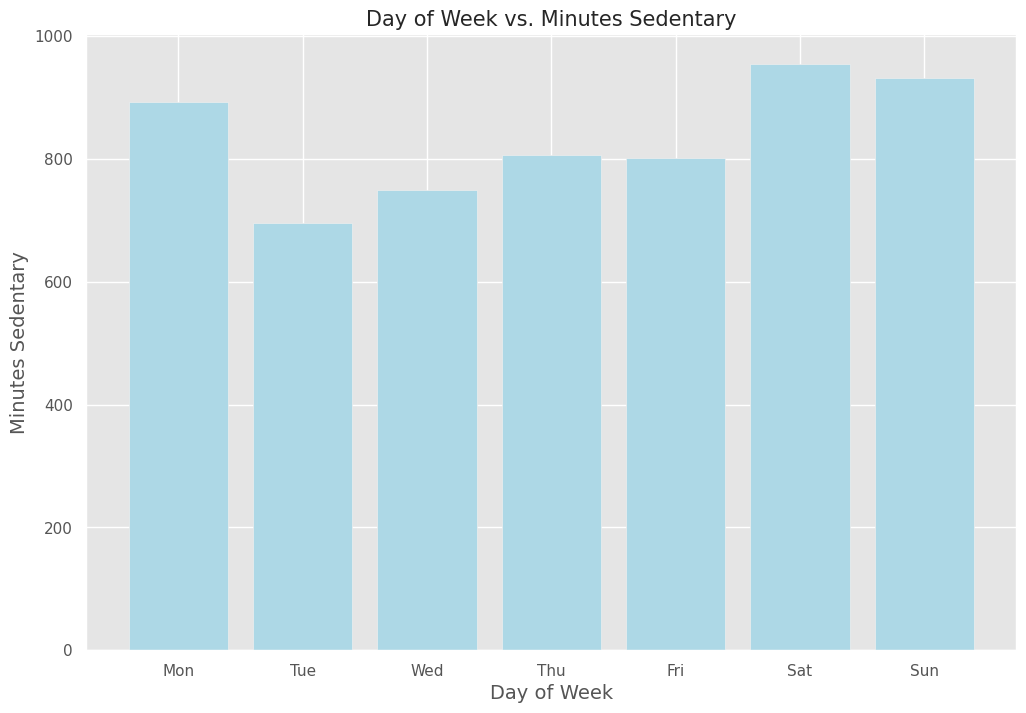

In [ ]:
# Weekly sedentary minutes

plt.bar(week_data.index, week_data['Minutes Sedentary'], color='lightblue', tick_label=min_names[1:])
plt.title('Day of Week vs. Minutes Sedentary', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes Sedentary', fontsize=14)

Average heart rate / calorie burn rate per min / vs exercise type

Analysing the amount of calories burned per minutes for various Activities shows some interesting findings.

In [ ]:

# sampleData
file_path_2 = '/content/drive/add-here-your-dataset.csv'

In [ ]:
activity_df = pd.read_csv(file_path_2)

In [ ]:
activity_df

,Date,Activity Type,Time,avgBPM,maxBPM,Calories burned,Steps
0,NaN,Running,10,149,NaN,124,NaN
1,NaN,Running,8,149,183.0,90,1202.0
2,NaN,Tennis,35,144,176.0,357,2507.0
3,NaN,Squash,44,139,170.0,427,4366.0
4,NaN,Swim,16,0,0.0,71,91.0
5,NaN,Swim,22,0,0.0,75,132.0
6,NaN,Swim,23,0,0.0,87,68.0
7,NaN,Fitbit Coach,10,131,149.0,86,5.0
8,NaN,Walk,20,121,164.0,182,2239.0
9,17-10-2018,Weight training,21,136,166.0,203,100.0


In [ ]:
activity_df['calories_burned_per_min'] = activity_df['Calories burned'] / activity_df['Time']

# average activity per type
activity_type = activity_df.groupby(['Activity Type']).mean(numeric_only=True)


Text(0, 0.5, 'Activity Type')

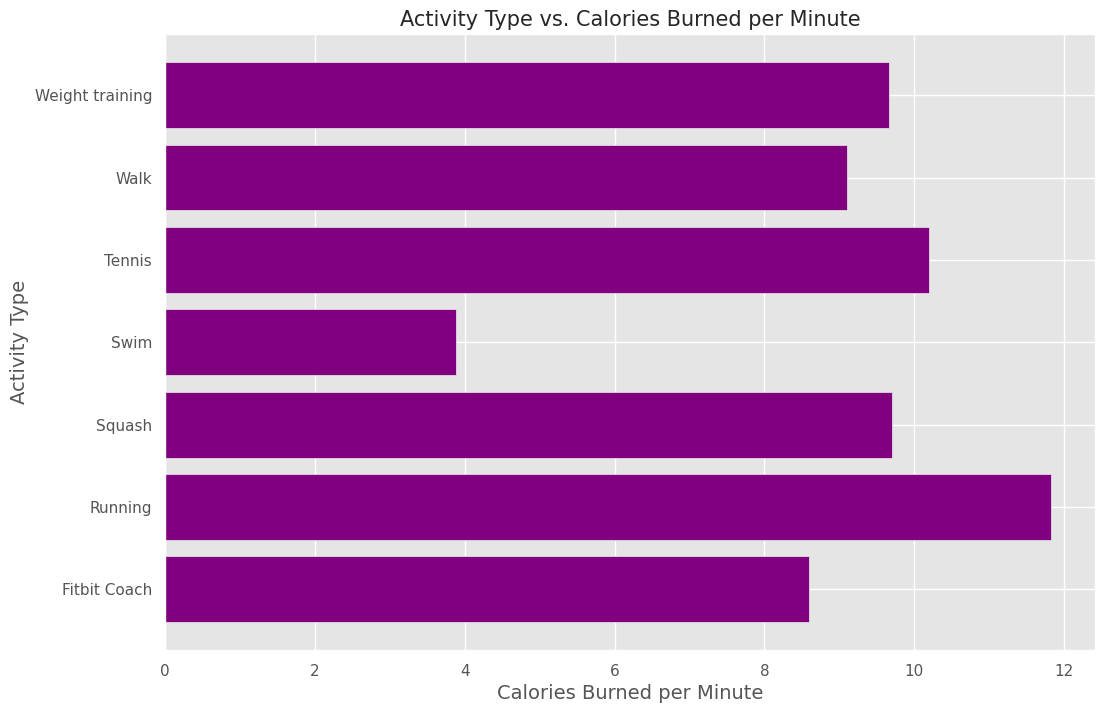

In [ ]:
# plot bar graph
plt.barh(activity_type.index, activity_type['calories_burned_per_min'], color='purple')
plt.title('Activity Type vs. Calories Burned per Minute', fontsize=15)
plt.xlabel('Calories Burned per Minute', fontsize=14)
plt.ylabel('Activity Type', fontsize=14)
#

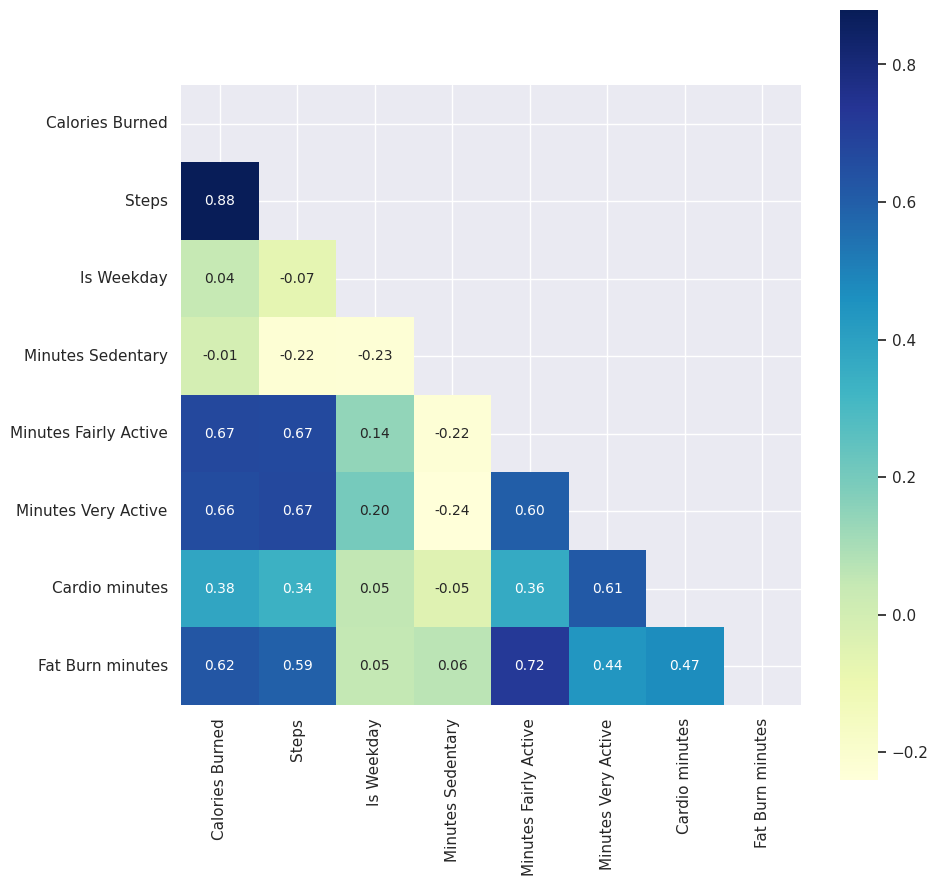

In [ ]:
 # Calorie burn corelation

correlationTitle = 'Calories Burned'
corrdf_calories = df[['Calories Burned','Steps', 'Is Weekday', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes']]
plot_heatmap(corrdf_calories.corr(), correlationTitle, '', darkTheme=True)
#

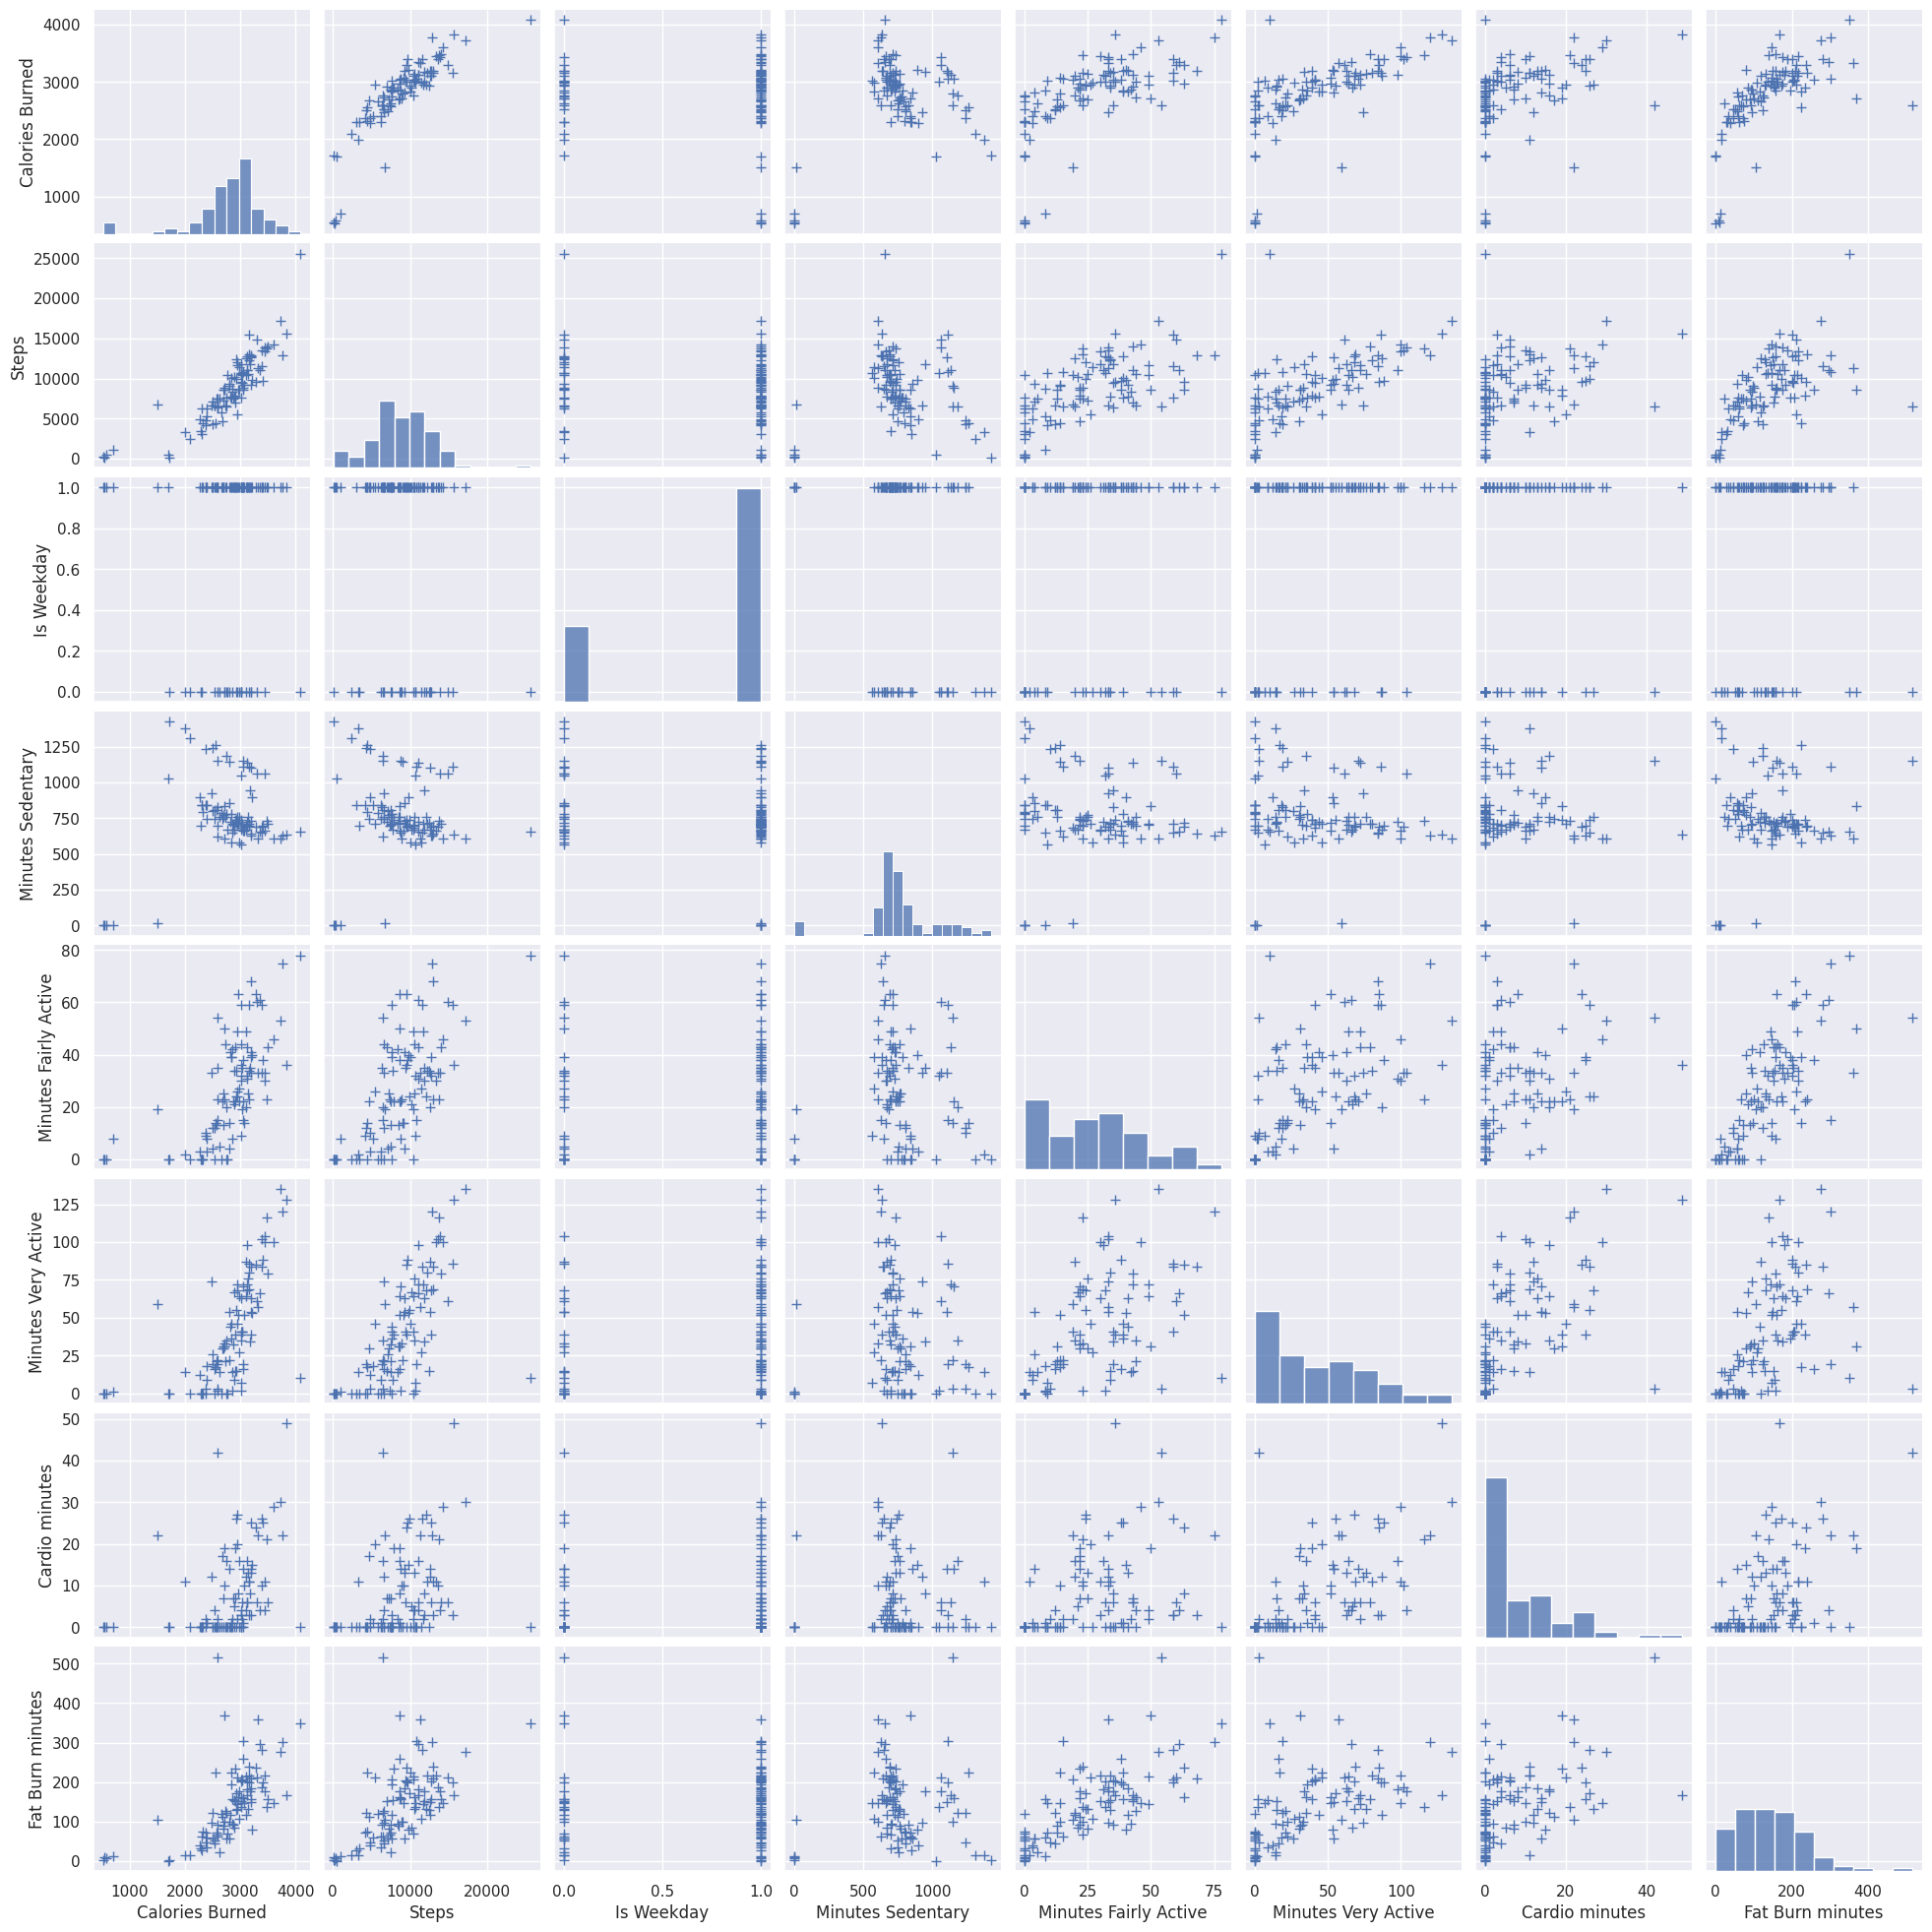

In [ ]:
# Basic correlogram
sns.pairplot(corrdf_calories.dropna(), kind='scatter', markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()


Calories burned is strongly correlated with both the number of steps taken and active minutes. Sedentary minutes show a negative correlation with weekdays, suggesting that I tend to be less active on weekends

**Sleep Analysis**

Sleep is crucial for mood, memory, and cognitive performance, and we spend about a third of our lives doing it—around 26 years! While metabolism slows, all major organs continue to function, making quality sleep essential.

Some proven ways to improve sleep include:
---
Following a consistent sleep schedule

Avoiding bright or blue light at night

Steering clear of late-day caffeine

Sleeping in a cool, dark room

Aiming for 7-9 hours of sleep (though some studies suggest benefits even with 5 hours)

During this experiment, lets see how we can maintain a sleep routine.

In [ ]:
from time import sleep
## Average sleep hours and the deviation

import matplotlib.dates as mdates

sleep_data = pd.DataFrame(df['Time in bed']/60).describe().transpose()
sleep_data

# average sleep hours
avg_sleep_hours = round(sleep_data.at['Time in bed', 'mean'], 2)
print(f'Average sleep hours: {avg_sleep_hours}')

title = 'Average sleep {} hours per day with std of {} hours'.format(avg_sleep_hours, round(sleep_data.at['Time in bed', 'std'], 2))

no_of_hours_in_bed = df['Time in bed']/60
#

Average sleep hours: 7.01


[]

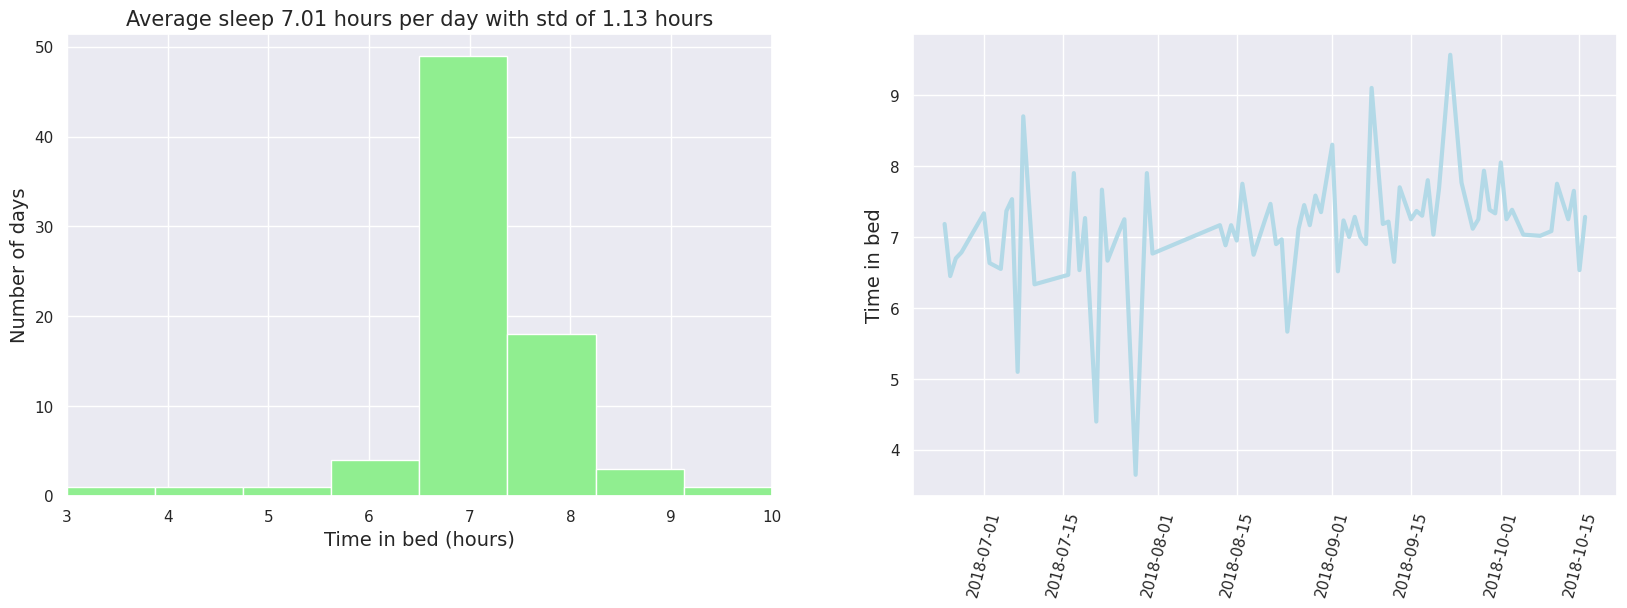

In [ ]:
# plot

fig = plt.figure(figsize = (20,6))

ax = fig.add_subplot(121)
plt.hist(no_of_hours_in_bed, bins = 8, range= (3,10), color='lightgreen')
plt.xlim(3,10)
plt.title(title, fontsize=15)
plt.xlabel('Time in bed (hours)', fontsize=14)
plt.ylabel('Number of days', fontsize=14)

##

ax = fig.add_subplot(122)
no_of_hours_in_bed_sleepData = sleepData['Time in bed']/60 # Calculate hours in bed using sleepData
plt.plot(sleepData['Date'], no_of_hours_in_bed_sleepData, linestyle='-',
         markersize=9, color='lightblue', label='% Light', linewidth=3.0, alpha=0.9)
plt.ylabel('Time in bed', fontsize=14)
ax2.axhline(avg_sleep_hours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75)
plt.plot()

In terms of behavioral data, this dataset is fairly consistent. The distribution is steep and shows little variation, with deviations of less than an hour.

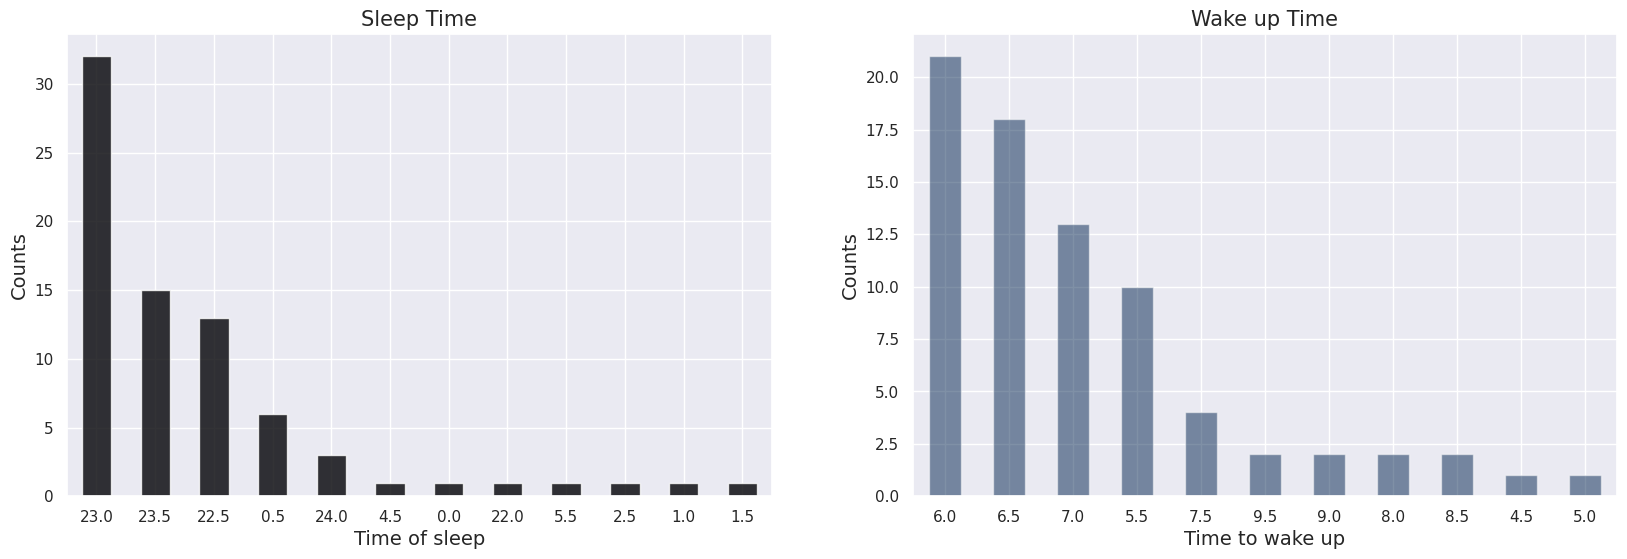

In [ ]:
# Average sleep and wake up timings

define_sleep_bucket = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed']]
define_sleep_bucket['Time in bed'] = define_sleep_bucket['Time in bed']/60

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)
pd.value_counts(sleepData['Sleep Bucket']).plot.bar(cmap='inferno', alpha=0.8)
plt.title('Sleep Time', fontsize=15)
plt.xlabel('Time of sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepData['Awake Bucket']).plot.bar(cmap='cividis', alpha=0.5)
plt.title('Wake up Time', fontsize=15)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.show()

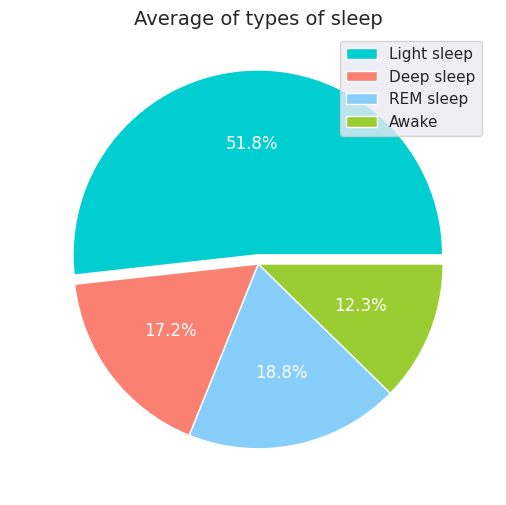

In [ ]:
# types of sleep
avgSleep = sleepData[['Minutes Light sleep', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Awake']].mean()

explode = [0.05, 0, 0, 0]
fig = plt.figure(figsize = (6,6))
sleep_types =['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']
plt.pie(avgSleep, colors = ['darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen'],
        autopct='%0.1f%%', labels=sleep_types, textprops=dict(color="w"), explode=explode)

plt.title('Average of types of sleep', fontsize=14)
plt.legend()
plt.show()

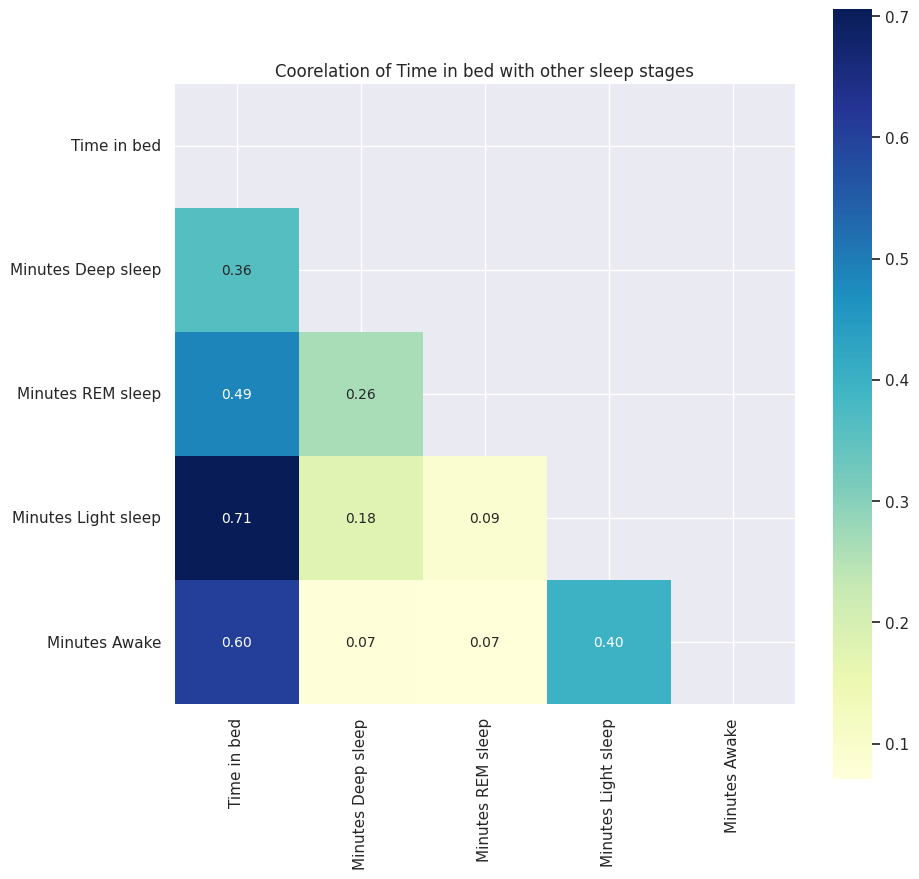

,Time in bed,Minutes Deep sleep,Minutes REM sleep,Minutes Light sleep,Minutes Awake
Time in bed,1.000000,0.363047,0.485731,0.705513,0.604619
Minutes Deep sleep,0.363047,1.000000,0.262515,0.178520,0.074543
Minutes REM sleep,0.485731,0.262515,1.000000,0.092427,0.070540
Minutes Light sleep,0.705513,0.178520,0.092427,1.000000,0.395523
Minutes Awake,0.604619,0.074543,0.070540,0.395523,1.000000


In [ ]:
# Correlation between amount of sleep and the sleep stages.

# Do sleeping more will help me attain more deep or REM sleep?

corrdf_sleep_types = sleepData[['Time in bed', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Light sleep', 'Minutes Awake']].corr().abs()
plot_heatmap(corrdf_sleep_types, correlationTitle, 'Coorelation of Time in bed with other sleep stages', darkTheme=True)
corrdf_sleep_types

Notice that 'Deep sleep minutes' are not strongly correlated with time spent in bed, indicating that simply sleeping longer doesn't necessarily lead to better deep sleep

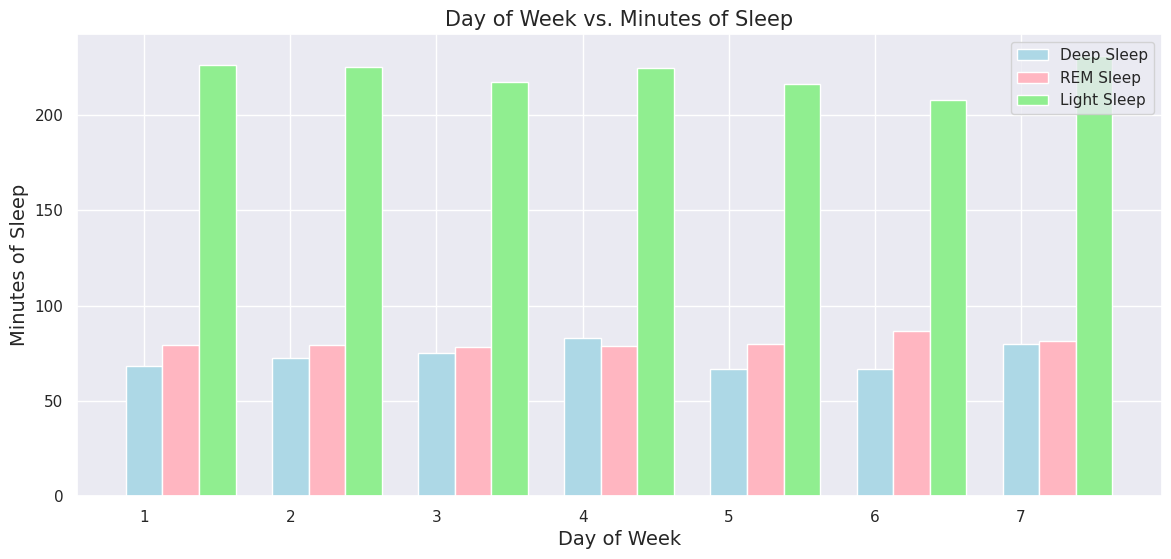

In [ ]:
# Types of Sleep based on different days

fig = plt.figure(figsize = (14,6))

bar_width = 0.25  # make the bars narrower

# x locations for groups
x = week_data.index

plt.bar(x, week_data['Minutes Deep sleep'],
        color='lightblue', width=bar_width, label='Deep Sleep')

plt.bar(x + bar_width, week_data['Minutes REM sleep'],
        color='lightpink', width=bar_width, label='REM Sleep')

plt.bar(x + 2*bar_width, week_data['Minutes Light sleep'],
        color='lightgreen', width=bar_width, label='Light Sleep')

plt.title('Day of Week vs. Minutes of Sleep', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes of Sleep', fontsize=14)
plt.legend(['Deep Sleep', 'REM Sleep', 'Light Sleep'])
#

Text(0.5, 1.0, '')

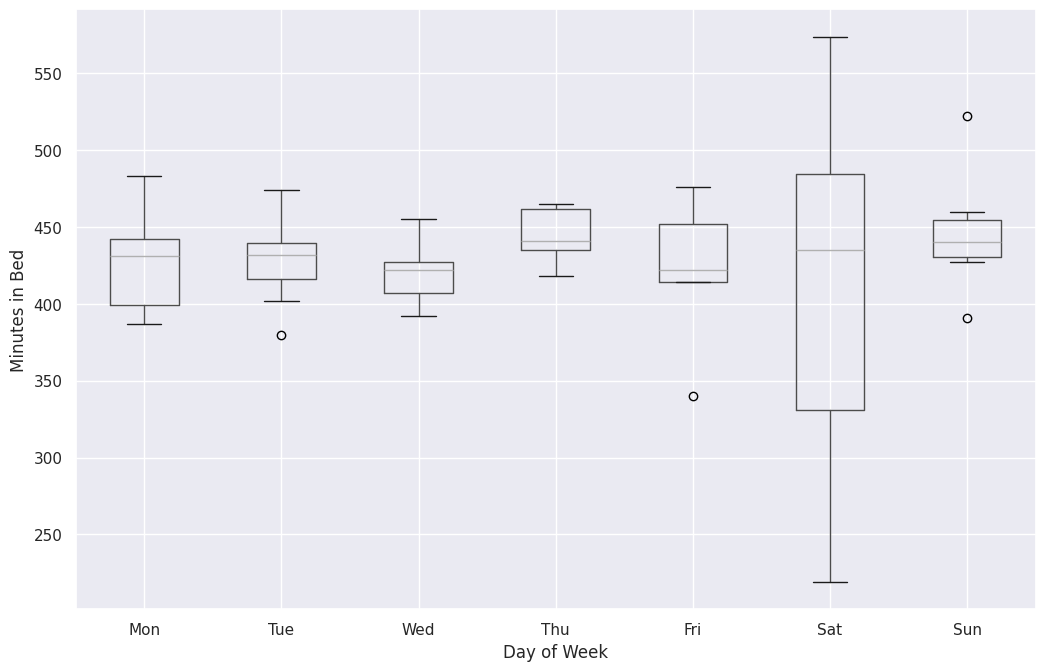

In [ ]:
# Effect of Sleep on Weekdays vs Weekends using boxplot

fig = sleepData.boxplot(column = 'Time in bed', by = 'Day of Week')
fig.set_xticklabels(min_names[1:])
plt.ylabel('Minutes in Bed')
plt.suptitle('')
plt.title('')



In [ ]:
# Corelation of sleep with other activity numbers

sleepData['8 > Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 8'] = sleepData['Time in bed'] > 8*60
sleepData['Active mins > 50'] = sleepData['Minutes Very Active'] > 50
sleepData['Active mins > 60'] = sleepData['Minutes Very Active'] > 60

sleepData['wee'] = np.logical_and(sleepData['Sleep Bucket'] <= 23, sleepData['Awake Bucket'] <= 6.5)

In [ ]:
correlationOf="Minutes Deep sleep"
k = 15 #number of variables for heatmap
corrmat = sleepData[['Minutes Deep sleep', 'Minutes Very Active', 'Minutes Fairly Active', 'Minutes Lightly Active', 'Minutes Sedentary', 'Calories Burned', 'Steps',
          'Cardio minutes', 'Fat Burn minutes', 'Peak minutes',
          '8 > Sleep > 7', 'wee', 'Sleep > 8', 'Active mins > 60', 'Is Weekday']].corr()

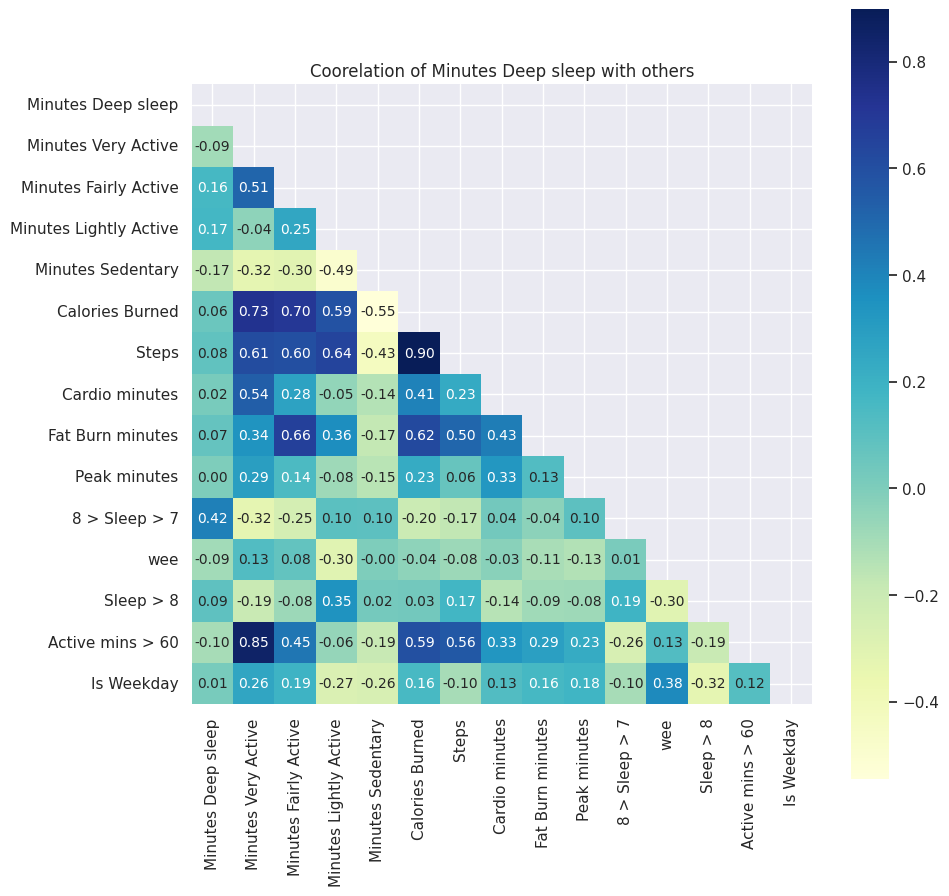

In [ ]:
plot_heatmap(corrmat, correlationOf, 'Coorelation of {} with others'.format(correlationOf), darkTheme=True)

Insights:

*Deep Sleep vs Time in Bed*: "Minutes Deep Sleep" shows a moderate positive correlation (0.42) with sleeping 7-8 hours, but very weak correlations with total time in bed over 8 hours (0.09). This suggests that longer sleep doesn't necessarily guarantee more deep sleep.

*Activity vs Deep Sleep*: There's little to no correlation between deep sleep and active minutes of any intensity (Very Active: -0.09, Fairly Active: 0.16, Lightly Active: 0.17), indicating that daily physical activity may not directly influence deep sleep.

*Sedentary Behavior*: Minutes Sedentary has a negative correlation with deep sleep (-0.17). Being sedentary slightly reduces deep sleep, but the effect is modest.

*Weekday Influence*: The “Is Weekday” variable shows almost no correlation with deep sleep (0.01), suggesting that weekday vs weekend doesn’t significantly impact deep sleep duration in this dataset.